# Imports and Library Setup

In [3]:
# --- Data handling and manipulation ---
import pandas as pd
import numpy as np
import os
import random

# --- Scikit-learn preprocessing, model selection, metrics ---
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# --- TensorFlow / Keras for deep learning ---
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# --- Visualization ---
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from IPython.display import display
import umap
from sklearn.decomposition import PCA


# Data Preprocessing

In [4]:
# Load gene expression data (log-transformed counts per cell)
logcounts = pd.read_csv("logcounts_scSNVseq_JAK1_cc_JAK_STAT.csv")

# Load list of gene names corresponding to rows/columns in logcounts
gene_names = pd.read_csv("gene_names.csv")

# Load metadata for genotyped cells (experimental conditions, labels, etc.)
metadata_genotyped = pd.read_csv("metadata_genotyped_experiment.csv")

In [5]:
# Create a mapping from gene aliases to standard gene names
mapping_gene_names = dict(zip(gene_names["converted_alias"], gene_names["name"]))

# Rename rows in logcounts using the standardized gene names
logcounts.rename(index=mapping_gene_names, inplace=True)

# Transpose logcounts so that rows = cells, columns = genes
data = logcounts.T

# Merge the transposed gene expression data with metadata (iBAR and consequence)
# Align rows based on the cell indices
data = pd.merge(
    data,
    metadata_genotyped[["iBAR", "consequence"]],
    how="left",
    left_on=data.index,
    right_on=metadata_genotyped.index
)

# Rename the temporary merge column to "cells"
data.rename(columns={"key_0": "cells"}, inplace=True)

# Prepare features for model input (all gene expression columns)
X_all = np.array(data.drop(columns=["iBAR", "consequence", "cells"])).astype(np.float32)

# Prepare labels for model output (iBAR and consequence)
y_all = np.array(data[["iBAR", "consequence"]])

In [6]:
# Initialize a label encoder to convert categorical labels to numeric values
label_encoder = LabelEncoder()

# Encode the "consequence" column (second column of y_all) as numeric labels
y = label_encoder.fit_transform(y_all[:, 1]).astype(np.float32)

# Split data into training and testing sets
# 80% training, 20% testing
# Use stratification to preserve label distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# Supervised Autoencoder

##Define Supervised Autoencoder

In [7]:
def supervised_autoencoder(input_dim,
                           latent_dim=16, units=[256, 64],
                           activation="relu", dropout=0.0,
                           learning_rate=0.001, optimizer="adam",
                           num_classes=7):
    """
    Defines a supervised autoencoder with an encoder, decoder, and classification head.

    Parameters:
    - input_dim: int, number of input features (genes)
    - latent_dim: int, size of latent space representation
    - units: list of ints, number of neurons in each hidden layer
    - activation: str, activation function for hidden layers
    - dropout: float, dropout rate (applied only once in first hidden layer if >0)
    - learning_rate: float, learning rate for optimizer
    - optimizer: str, "adam" or "sgd"
    - num_classes: int, number of classes for supervised classification

    Returns:
    - autoencoder: Keras Model, full autoencoder with reconstruction + classification outputs
    - encoder: Keras Model, encoder part returning latent representation
    """

    # ----- Encoder -----
    inputs = layers.Input(shape=(input_dim,))  # Input layer
    x = inputs
    dropout_cond = False  # Ensure dropout is applied only once
    for h in units:
        x = layers.Dense(h, activation=activation)(x)  # Hidden dense layers
        if dropout > 0 and not dropout_cond:
            x = layers.Dropout(dropout)(x)  # Apply dropout to first layer if specified
            dropout_cond = True
    latent = layers.Dense(latent_dim, name="latent")(x)  # Latent space representation

    # ----- Decoder -----
    x = latent
    for h in reversed(units):
        x = layers.Dense(h, activation=activation)(x)  # Mirror hidden layers
    reconstructed = layers.Dense(input_dim, name="reconstruction")(x)  # Output layer for reconstruction

    # ----- Supervised classification head -----
    supervised_out = layers.Dense(num_classes, activation="softmax", name="classification")(latent)

    # ----- Define Models -----
    autoencoder = models.Model(inputs, [reconstructed, supervised_out], name="SupervisedAutoencoder")
    encoder = models.Model(inputs, latent, name="Encoder")

    # ----- Class weights for handling imbalanced classes -----
    classes = np.unique(y_train)  # Unique labels
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights_dict = dict(zip(classes, class_weights))

    # ----- Weighted loss function for classification -----
    classes_tf = tf.constant(classes, dtype=tf.int32)
    def weighted_scc(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        indices = tf.searchsorted(classes_tf, y_true)
        weights = tf.gather(tf.constant([class_weights_dict[c] for c in classes], dtype=tf.float32), indices)
        scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        return scce * weights

    # ----- Compile autoencoder -----
    opt = Adam(learning_rate=learning_rate) if optimizer == 'adam' else SGD(learning_rate=learning_rate)
    autoencoder.compile(
        optimizer=opt,
        loss={"reconstruction": "mse", "classification": weighted_scc},
        loss_weights={"reconstruction": 0.5, "classification": 1.0},
        metrics={"classification": "accuracy"}
    )

    return autoencoder, encoder

In [8]:
# Determine the number of unique classes in the training labels
num_classes = len(np.unique(y_train))

# Instantiate the supervised autoencoder with specified hyperparameters
autoencoder, encoder = supervised_autoencoder(
    input_dim=X_train.shape[1],
    latent_dim=3,
    units=(256, 64),
    dropout=0.0,
    activation="relu",
    learning_rate=0.0001,
    optimizer="adam",
    num_classes=num_classes
)

# Print a summary of the autoencoder model architecture
autoencoder.summary()

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "SupervisedAutoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 271)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     69,632 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     16,448 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent (Dense)      │ (None, 3)         │        195 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        256 │ latent[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     16,640 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reconstruction      │ (None, 271)       │     69,647 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 7)         │         28 │ latent[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 172,846 (675.18 KB)

 Trainable params: 172,846 (675.18 KB)

 Non-trainable params: 0 (0.00 B)

## Set Random Seed for Reproducibility

In [9]:
# Set a fixed seed value for reproducibility
SEED = 42

def set_seed():
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

    # Force deterministic TensorFlow behavior
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["PYTHONHASHSEED"] = str(SEED)

    # Enable GPU determinism (optional, may reduce performance)
    tf.config.experimental.enable_op_determinism()

## Hyperparameter Grid Search and Model Training

In [10]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define grid of hyperparameters for tuning
param_grid = {
    'latent_dim_units': {
        (2, 3, 5, 8): [(128, 16), (256, 64, 8)],
        (12, 18, 27): [(128, 32), (256, 128, 64)],
        (41, 61): [(256, 128), (512, 128)],
        (92, 137, 205): [(512, 256), (1024, 256)]
    },
    'activation': ['relu'],
    'optimizer': ['adam'],
    'learning_rate': [1e-4],
    'dropout': [0]
}

# Training settings
EPOCHS = 100
BATCH_SIZE = 128

# Tracking the best model and loss history
best_val_loss = 100
best_models = {}
losses_history = []
best_autoencoder_history = None

# Hyperparameter search loop
for latent_group, unit_options in param_grid['latent_dim_units'].items():
    for latent_dim in latent_group:
        min_losses_dim =[100, 100]
        for units in unit_options:
            for activation in param_grid['activation']:
                for optimizer_name in param_grid['optimizer']:
                    for learning_rate in param_grid['learning_rate']:
                        for dropout in param_grid['dropout']:
                            print(f"Training: latent_dim={latent_dim}, units={units}, "
                                  f"activation={activation}, optimizer={optimizer_name}, lr={learning_rate}, dropout={dropout}")

                            # Set random seed for reproducibility
                            set_seed()

                            # Initialize supervised autoencoder with current hyperparameters
                            autoencoder, encoder = supervised_autoencoder(
                                input_dim=X_train.shape[1],
                                latent_dim=latent_dim,
                                units=units,
                                dropout=dropout,
                                learning_rate=learning_rate,
                                optimizer=optimizer_name,
                                activation=activation,
                                num_classes=num_classes
                            )

                            # Train the autoencoder
                            history = autoencoder.fit(
                                X_train,
                                {"reconstruction": X_train, "classification": y_train},
                                validation_split=0.2,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                verbose=1,
                                callbacks=[early_stop]
                            )

                            # Get the minimum validation loss and training loss
                            val_loss = min(history.history['val_loss'])
                            print(f"→ Val Loss: {val_loss:.4f} | Loss: {min(history.history['loss']): .4f}")

                            # Update best model for this latent dimension
                            if val_loss < min_losses_dim[0]:
                                min_losses_dim[0] = val_loss
                                min_losses_dim[1] = min(history.history['loss'])

                                best_models[latent_dim] = {
                                    'autoencoder': autoencoder,
                                    'encoder': encoder,
                                    'history': history,
                                    'config': {
                                        'units': units,
                                        'activation': activation,
                                        'optimizer': optimizer_name,
                                        'learning_rate': learning_rate,
                                        'dropout': dropout
                                    }
                                }

        # Append losses for the latent dimension to history
        losses_history.append([min(history.history['val_loss']), min(history.history['loss'])])

# Convert losses history to numpy array for easier analysis
losses_history = np.array(losses_history)

Training: latent_dim=2, units=(128, 16), activation=relu, optimizer=adam, lr=0.0001, dropout=0
Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - classification_accuracy: 0.0645 - classification_loss: 2.0338 - loss: 2.3341 - reconstruction_loss: 0.6005 - val_classification_accuracy: 0.1304 - val_classification_loss: 1.9302 - val_loss: 2.2207 - val_reconstruction_loss: 0.5803
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - classification_accuracy: 0.1256 - classification_loss: 1.9774 - loss: 2.2609 - reconstruction_loss: 0.5668 - val_classification_accuracy: 0.1992 - val_classification_loss: 1.9226 - val_loss: 2.1776 - val_reconstruction_loss: 0.5105
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - classification_accuracy: 0.2235 - classification_loss: 1.9579 - loss: 2.1982 - reconstruction_loss: 0.4806 - val_classification_accuracy: 0.3714 - val_classification_loss: 1.9255 - val_loss: 2.1117 - val_reconstruction_loss: 0.3730
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

##Find Optimal Latent Dimension

Elbow found at index 4, corresponding latent dimension: 12


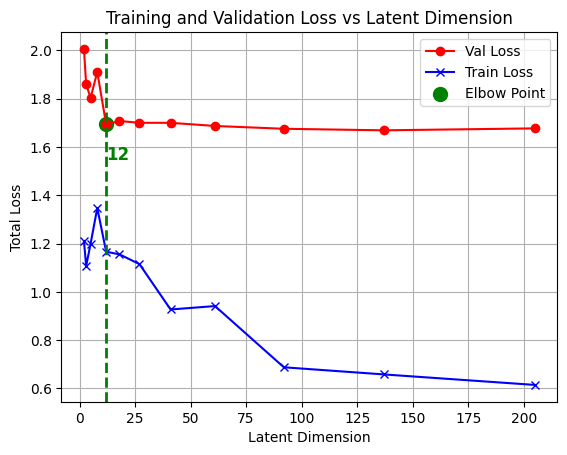

In [11]:
# latent_dim already extracted from param_grid keys
latent_dim = [x for group in param_grid['latent_dim_units'].keys() for x in group]

# Function to find elbow point
def find_elbow(dims, errors):
    """
    Return the index and dim of the elbow (max perpendicular distance to line from first to last).
    dims: 1D array-like (increasing)
    errors: 1D array-like (same length)
    """
    x = np.array(dims, dtype=float)
    y = np.array(errors, dtype=float)

    # Line from first to last point
    x1, y1 = x[0], y[0]
    x2, y2 = x[-1], y[-1]

    # Perpendicular distances to line
    num = np.abs((y2 - y1)*x - (x2 - x1)*y + x2*y1 - y2*x1)
    den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    dists = num / den

    idx = int(np.argmax(dists))
    return idx, int(x[idx])

# Compute elbow
elbow_idx, elbow_dim = find_elbow(latent_dim, np.array(losses_history[:, 0]))
print(f"Elbow found at index {elbow_idx}, corresponding latent dimension: {elbow_dim}")

# Plot losses with elbow highlighted
plt.plot(latent_dim, losses_history[:, 0], label="Val Loss", c="r", marker='o')
plt.plot(latent_dim, losses_history[:, 1], label="Train Loss", c="b", marker='x')
plt.scatter(latent_dim[elbow_idx], losses_history[elbow_idx, 0], c='green', s=100, label="Elbow Point")
plt.axvline(x=latent_dim[elbow_idx], color='green', linestyle='--', linewidth=2)
plt.text(latent_dim[elbow_idx], max(losses_history[:, 0])*0.8, f"{elbow_dim}",
         color='green', fontsize=12, ha='left', va='top', fontweight='bold')
plt.legend()
plt.grid(True)
plt.xlabel("Latent Dimension")
plt.ylabel("Total Loss")
plt.title("Training and Validation Loss vs Latent Dimension")
plt.savefig("loss_vs_latent_dim.pdf")
plt.show()



In [21]:
# Select the best model corresponding to the chosen latent dimension (elbow point)
best_model = best_models[elbow_dim]

# Extract the autoencoder from the best model
best_autoencoder = best_model['autoencoder']

# Extract only the encoder part of the autoencoder for latent space representation
best_encoder = best_model['encoder']

##Compute Most Important Genes

In [20]:
# --- 1. Ensure float32 tensor ---
# We cast to float32 to match standard TensorFlow layer weights
X_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
feature_names = logcounts.index.tolist()

# --- 2. Compute Gradients (Sensitivity Analysis) ---
with tf.GradientTape() as tape:
    tape.watch(X_tensor)
    latent_output = best_encoder(X_tensor)  # shape: (n_samples, latent_dim)

# Calculate gradient of the latent representation w.r.t the input
grads = tape.gradient(latent_output, X_tensor)

# --- 3. Process Gradients ---
grads_np = grads.numpy()

# Handle shape variations based on your model architecture
if grads_np.ndim == 2:
    # Shape: (n_samples, n_features)
    # We aggregate across samples (axis 0)
    feature_importance_latent = np.abs(grads_np).mean(axis=0)[:, None]
else:
    # Shape: (n_samples, n_features, latent_dim) or similar 3D structure
    feature_importance_latent = np.abs(grads_np).mean(axis=0)

# Calculate overall importance by averaging across latent dimensions/channels
# resulting in a 1D array of shape (n_features,)
feature_importance_overall = feature_importance_latent.mean(axis=1)

# --- 4. Create Sorted DataFrame ---
feature_importance_df = pd.DataFrame({
    "Gene": feature_names,
    "Importance": feature_importance_overall
}).sort_values("Importance", ascending=False)

# Round for readability
feature_importance_df["Importance"] = feature_importance_df["Importance"].round(4)

# --- 5. Prepare Side-by-Side Comparison ---
top_15 = feature_importance_df.head(15).reset_index(drop=True)
bottom_15 = feature_importance_df.tail(15).reset_index(drop=True)

# Combine into one table
combined_df = pd.concat([top_15, bottom_15], axis=1)

# --- Updated Column Names ---
combined_df.columns = [
    "Top Genes",         # Clearer than "Most Important Genes"
    "Importance Score",  # Standard nomenclature
    "Bottom Genes",      # Clearer than "Least Important Genes"
    "Importance Score"   # Reused for consistency
]

# --- 6. Display Results ---
print("="*70)
print("Feature Importance Analysis: Highest vs. Lowest Sensitivity")
print("="*70)
display(combined_df)

Feature Importance Analysis: Highest vs. Lowest Sensitivity


,Top Genes,Importance Score,Bottom Genes,Importance Score
0,STAT1,0.3357,IL11,0.0831
1,PCNA,0.2964,CHEK1,0.0830
2,ANAPC13,0.2872,CCNB3,0.0812
3,SOCS2,0.2853,TFDP1,0.0811
4,TGFB3,0.2600,SPRY2,0.0807
5,TGFB1,0.2541,CDC20,0.0802
6,ORC1,0.2535,RBL1,0.0789
7,SOCS5,0.2459,PIAS2,0.0787
8,IL12RB1,0.2455,IFNA17,0.0785
9,SMAD3,0.2378,IFNW1,0.0758


In [15]:
# ===== Evaluate Reconstruction Error on Train and Test Sets =====
# This section computes the Mean Squared Error (MSE) between the original input
# data and its reconstruction produced by the autoencoder.
# Lower MSE values indicate better reconstruction quality.


# ---- Test Set Reconstruction ----
# Predict the reconstructed output for the test set
y_test_pred = best_autoencoder.predict(X_test)[0]

# Compute Mean Squared Error (MSE) between true and reconstructed inputs
reconstruction_error_test = mean_squared_error(X_test, y_test_pred)
print(f"Reconstruction Error (MSE) on Test Set: {reconstruction_error_test:.6f}")

# ---- Train Set Reconstruction ----
# Predict the reconstructed output for the training set
y_train_pred = best_autoencoder.predict(X_train)[0]

# Compute MSE between training inputs and their reconstructions
reconstruction_error_train = mean_squared_error(X_train, y_train_pred)
print(f"Reconstruction Error (MSE) on Train Set: {reconstruction_error_train:.6f}")

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Reconstruction Error (MSE) on Test Set: 0.220887
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Reconstruction Error (MSE) on Train Set: 0.221444


#Visualisation

475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train encoded shape: (15182, 12)
Test encoded shape: (3796, 12)


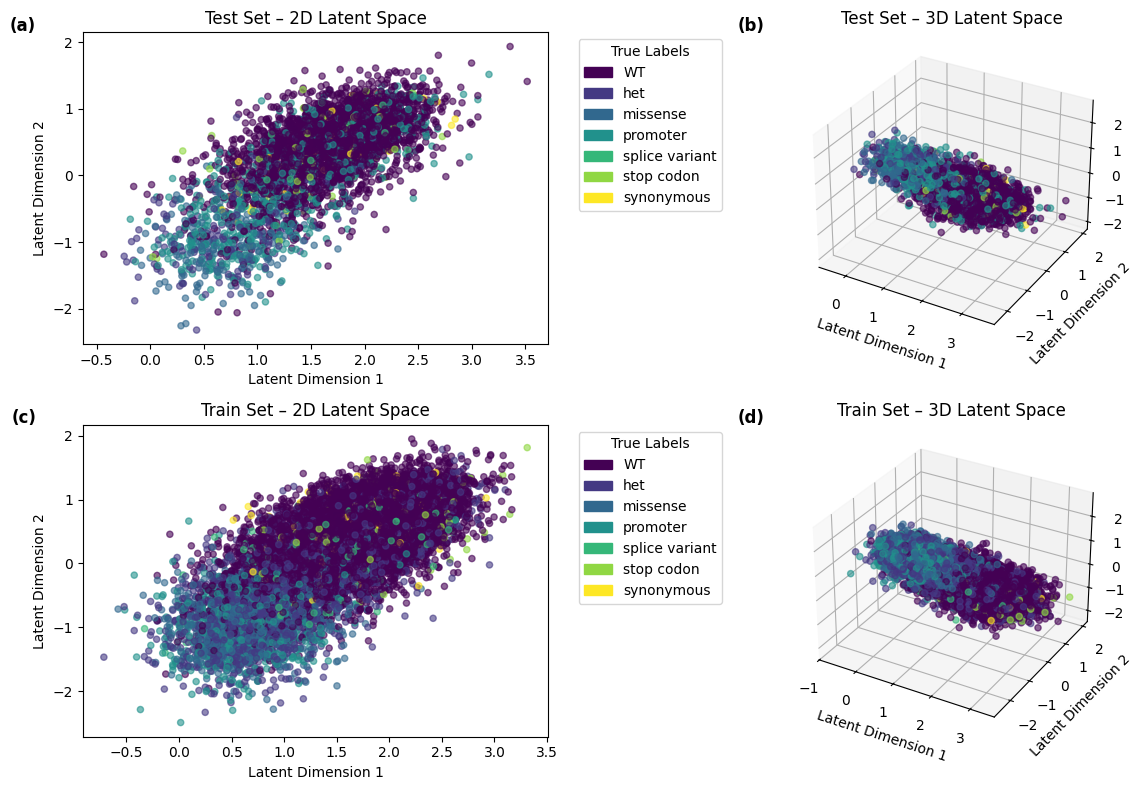

In [16]:
# ===== Visualization of Latent Space (Train vs Test, 2D and 3D) =====
# This code visualizes the latent space representations learned by the trained
# encoder (best_encoder) for both training and test datasets. It shows 2D and
# 3D projections of the encoded data, coloured by true labels for comparison.

# ---- Encode both Train and Test datasets ----
X_train_encoded = best_encoder.predict(X_train)
X_test_encoded = best_encoder.predict(X_test)
print("Train encoded shape:", X_train_encoded.shape)
print("Test encoded shape:", X_test_encoded.shape)

# Decode label indices back to their original form (if labels were encoded)
true_labels_train = label_encoder.inverse_transform(np.array(y_train).astype(int))
true_labels_test = label_encoder.inverse_transform(np.array(y_test).astype(int))

# ---- Create a 2x2 figure grid ----
fig = plt.figure(figsize=(12, 8))

# ===== (a) Test Set – 2D Latent Space =====
ax1 = fig.add_subplot(2, 2, 1)
sc1 = ax1.scatter(
    X_test_encoded[:, 0],
    X_test_encoded[:, 1],
    c=pd.factorize(true_labels_test)[0],
    alpha=0.6,
    s=20
)

# Create legend for test set
unique_labels_test = np.unique(true_labels_test)
colours_test = [sc1.cmap(sc1.norm(i)) for i in range(len(unique_labels_test))]
patches_test = [mpatches.Patch(color=c, label=l) for c, l in zip(colours_test, unique_labels_test)]
ax1.legend(handles=patches_test, title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels and title
ax1.set_title('Test Set – 2D Latent Space')
ax1.set_xlabel('Latent Dimension 1')
ax1.set_ylabel('Latent Dimension 2')
ax1.text(-0.1, 1.05, "(a)", transform=ax1.transAxes,
         fontsize=12, fontweight='bold', va='top', ha='right')

# ===== (b) Test Set – 3D Latent Space =====
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
sc2 = ax2.scatter(
    X_test_encoded[:, 0],
    X_test_encoded[:, 1],
    X_test_encoded[:, 2],
    c=pd.factorize(true_labels_test)[0],
    alpha=0.6,
    s=20
)
ax2.set_title('Test Set – 3D Latent Space')
ax2.set_xlabel('Latent Dimension 1')
ax2.set_ylabel('Latent Dimension 2')
ax2.set_zlabel('Latent Dimension 3')
ax2.text2D(-0.1, 1.05, "(b)", transform=ax2.transAxes,
           fontsize=12, fontweight='bold', va='top', ha='right')

# ===== (c) Train Set – 2D Latent Space =====
ax3 = fig.add_subplot(2, 2, 3)
sc3 = ax3.scatter(
    X_train_encoded[:, 0],
    X_train_encoded[:, 1],
    c=pd.factorize(true_labels_train)[0],
    alpha=0.6,
    s=20
)

# Create legend for train set
unique_labels_train = np.unique(true_labels_train)
colours_train = [sc3.cmap(sc3.norm(i)) for i in range(len(unique_labels_train))]
patches_train = [mpatches.Patch(color=c, label=l) for c, l in zip(colours_train, unique_labels_train)]
ax3.legend(handles=patches_train, title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels and title
ax3.set_title('Train Set – 2D Latent Space')
ax3.set_xlabel('Latent Dimension 1')
ax3.set_ylabel('Latent Dimension 2')
ax3.text(-0.1, 1.05, "(c)", transform=ax3.transAxes,
         fontsize=12, fontweight='bold', va='top', ha='right')

# ===== (d) Train Set – 3D Latent Space =====
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
sc4 = ax4.scatter(
    X_train_encoded[:, 0],
    X_train_encoded[:, 1],
    X_train_encoded[:, 2],
    c=pd.factorize(true_labels_train)[0],
    alpha=0.6,
    s=20
)
ax4.set_title('Train Set – 3D Latent Space')
ax4.set_xlabel('Latent Dimension 1')
ax4.set_ylabel('Latent Dimension 2')
ax4.set_zlabel('Latent Dimension 3')
ax4.text2D(-0.1, 1.05, "(d)", transform=ax4.transAxes,
           fontsize=12, fontweight='bold', va='top', ha='right')

# ---- Final layout and saving ----
plt.tight_layout()
plt.savefig("latent_space_train_test_comparison.pdf")
plt.show()

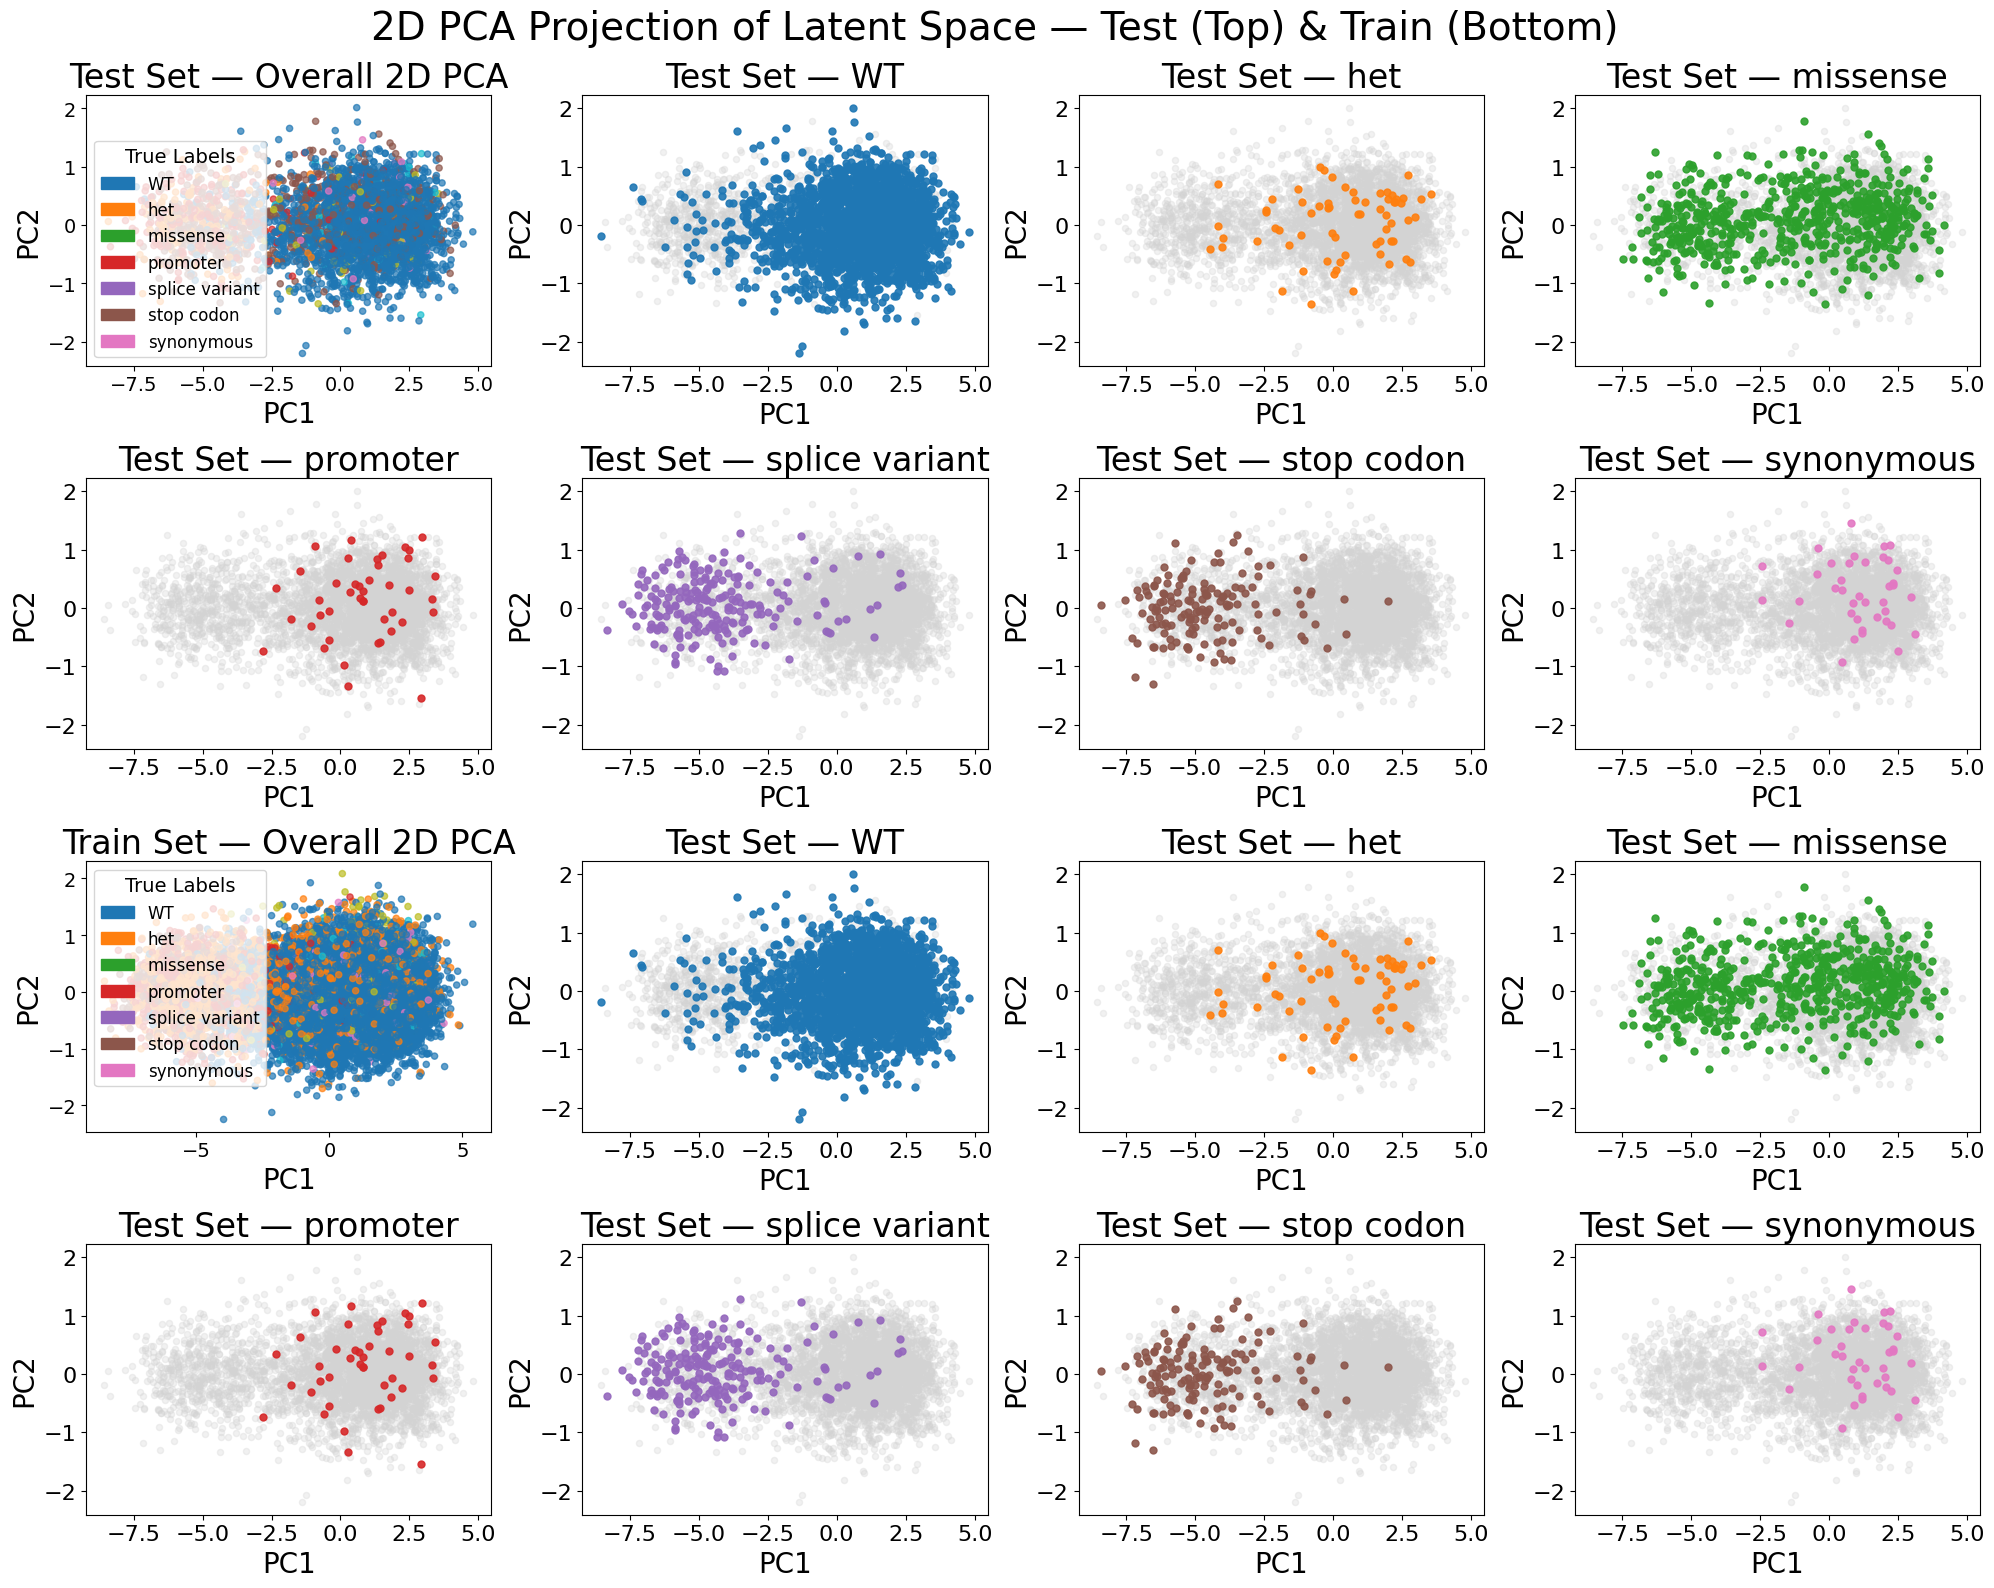

In [67]:
# ===== 2D PCA Visualization of Encoded Latent Space (4x4 Grid) =====

# ---- Apply PCA to encoded representations ----
pca_test = PCA(n_components=3)
latent_test = pca_test.fit_transform(X_test_encoded)

pca_train = PCA(n_components=3)
latent_train = pca_train.fit_transform(X_train_encoded)

# ---- Prepare labels ----
true_labels_test = label_encoder.inverse_transform(np.array(y_test).astype(int))
true_labels_train = label_encoder.inverse_transform(np.array(y_train).astype(int))
unique_labels = np.unique(true_labels_train)

# ---- Consistent modern colormap ----
colormap = plt.colormaps.get_cmap('tab10') # Fixed: Removed extra argument

# ---- Define grid size ----
n_rows, n_cols = 4, 4  # 4x4 grid
total_slots = n_rows * n_cols

# ---- Create figure ----
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# ===========================================================
#                     TEST SET (Top Half)
# ===========================================================
# Overall plot
sc = axes[0].scatter(
    latent_test[:, 0], latent_test[:, 1],
    c=pd.factorize(true_labels_test)[0], # Fixed: Changed to true_labels_test
    cmap=colormap, alpha=0.7, s=20
)
axes[0].set_title('Test Set — Overall 2D PCA', fontsize=24)
axes[0].set_xlabel('PC1', fontsize=20)
axes[0].set_ylabel('PC2', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=14)

# Legend
colours = [colormap(i) for i in range(len(unique_labels))]
patches = [mpatches.Patch(color=c, label=l) for c, l in zip(colours, unique_labels)]
axes[0].legend(handles=patches, title="True Labels", title_fontsize=14, fontsize=12)

# Individual class plots
for i, label in enumerate(unique_labels):
    idx = i + 1
    mask = (true_labels_test == label) # Use true_labels_test for masking test data
    axes[idx].scatter(latent_test[~mask, 0], latent_test[~mask, 1],
                      color='lightgrey', alpha=0.3, s=20)
    axes[idx].scatter(latent_test[mask, 0], latent_test[mask, 1],
                      color=colormap(i), alpha=0.9, s=25)
    axes[idx].set_title(f'Test Set — {label}', fontsize=24)
    axes[idx].set_xlabel('PC1', fontsize=20)
    axes[idx].set_ylabel('PC2', fontsize=20)
    axes[idx].tick_params(axis='both', which='major', labelsize=16)
    axes[idx].grid(False)

# Fill empty slots (if any)
for j in range(len(unique_labels) + 1, total_slots // 2):
    axes[j].axis('off')

# ===========================================================
#                     TRAIN SET (Bottom Half)
# ===========================================================
sc = axes[total_slots // 2].scatter(
    latent_train[:, 0], latent_train[:, 1],
    c=pd.factorize(true_labels_train)[0],
    cmap=colormap, alpha=0.7, s=20
)
axes[total_slots // 2].set_title('Train Set — Overall 2D PCA', fontsize=24)
axes[total_slots // 2].set_xlabel('PC1', fontsize=20)
axes[total_slots // 2].set_ylabel('PC2', fontsize=20)
axes[total_slots // 2].tick_params(axis='both', which='major', labelsize=14)
axes[total_slots // 2].legend(handles=patches, title="True Labels",
                              title_fontsize=14, fontsize=12)

# Individual class plots
for i, label in enumerate(unique_labels):
    idx = total_slots // 2 + i + 1
    mask = (true_labels_test == label) # Use true_labels_test for masking test data
    axes[idx].scatter(latent_test[~mask, 0], latent_test[~mask, 1],
                      color='lightgrey', alpha=0.3, s=20)
    axes[idx].scatter(latent_test[mask, 0], latent_test[mask, 1],
                      color=colormap(i), alpha=0.9, s=25)
    axes[idx].set_title(f'Test Set — {label}', fontsize=24)
    axes[idx].set_xlabel('PC1', fontsize=20)
    axes[idx].set_ylabel('PC2', fontsize=20)
    axes[idx].tick_params(axis='both', which='major', labelsize=16)

    axes[idx].grid(False)

# Fill remaining slots
for j in range(total_slots // 2 + len(unique_labels) + 1, total_slots):
    axes[j].axis('off')

# ---- Final layout ----
plt.suptitle('2D PCA Projection of Latent Space — Test (Top) & Train (Bottom)', fontsize=28, y=0.99)
plt.tight_layout()
plt.savefig("latent_space_pca_comparison.pdf", bbox_inches='tight')
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


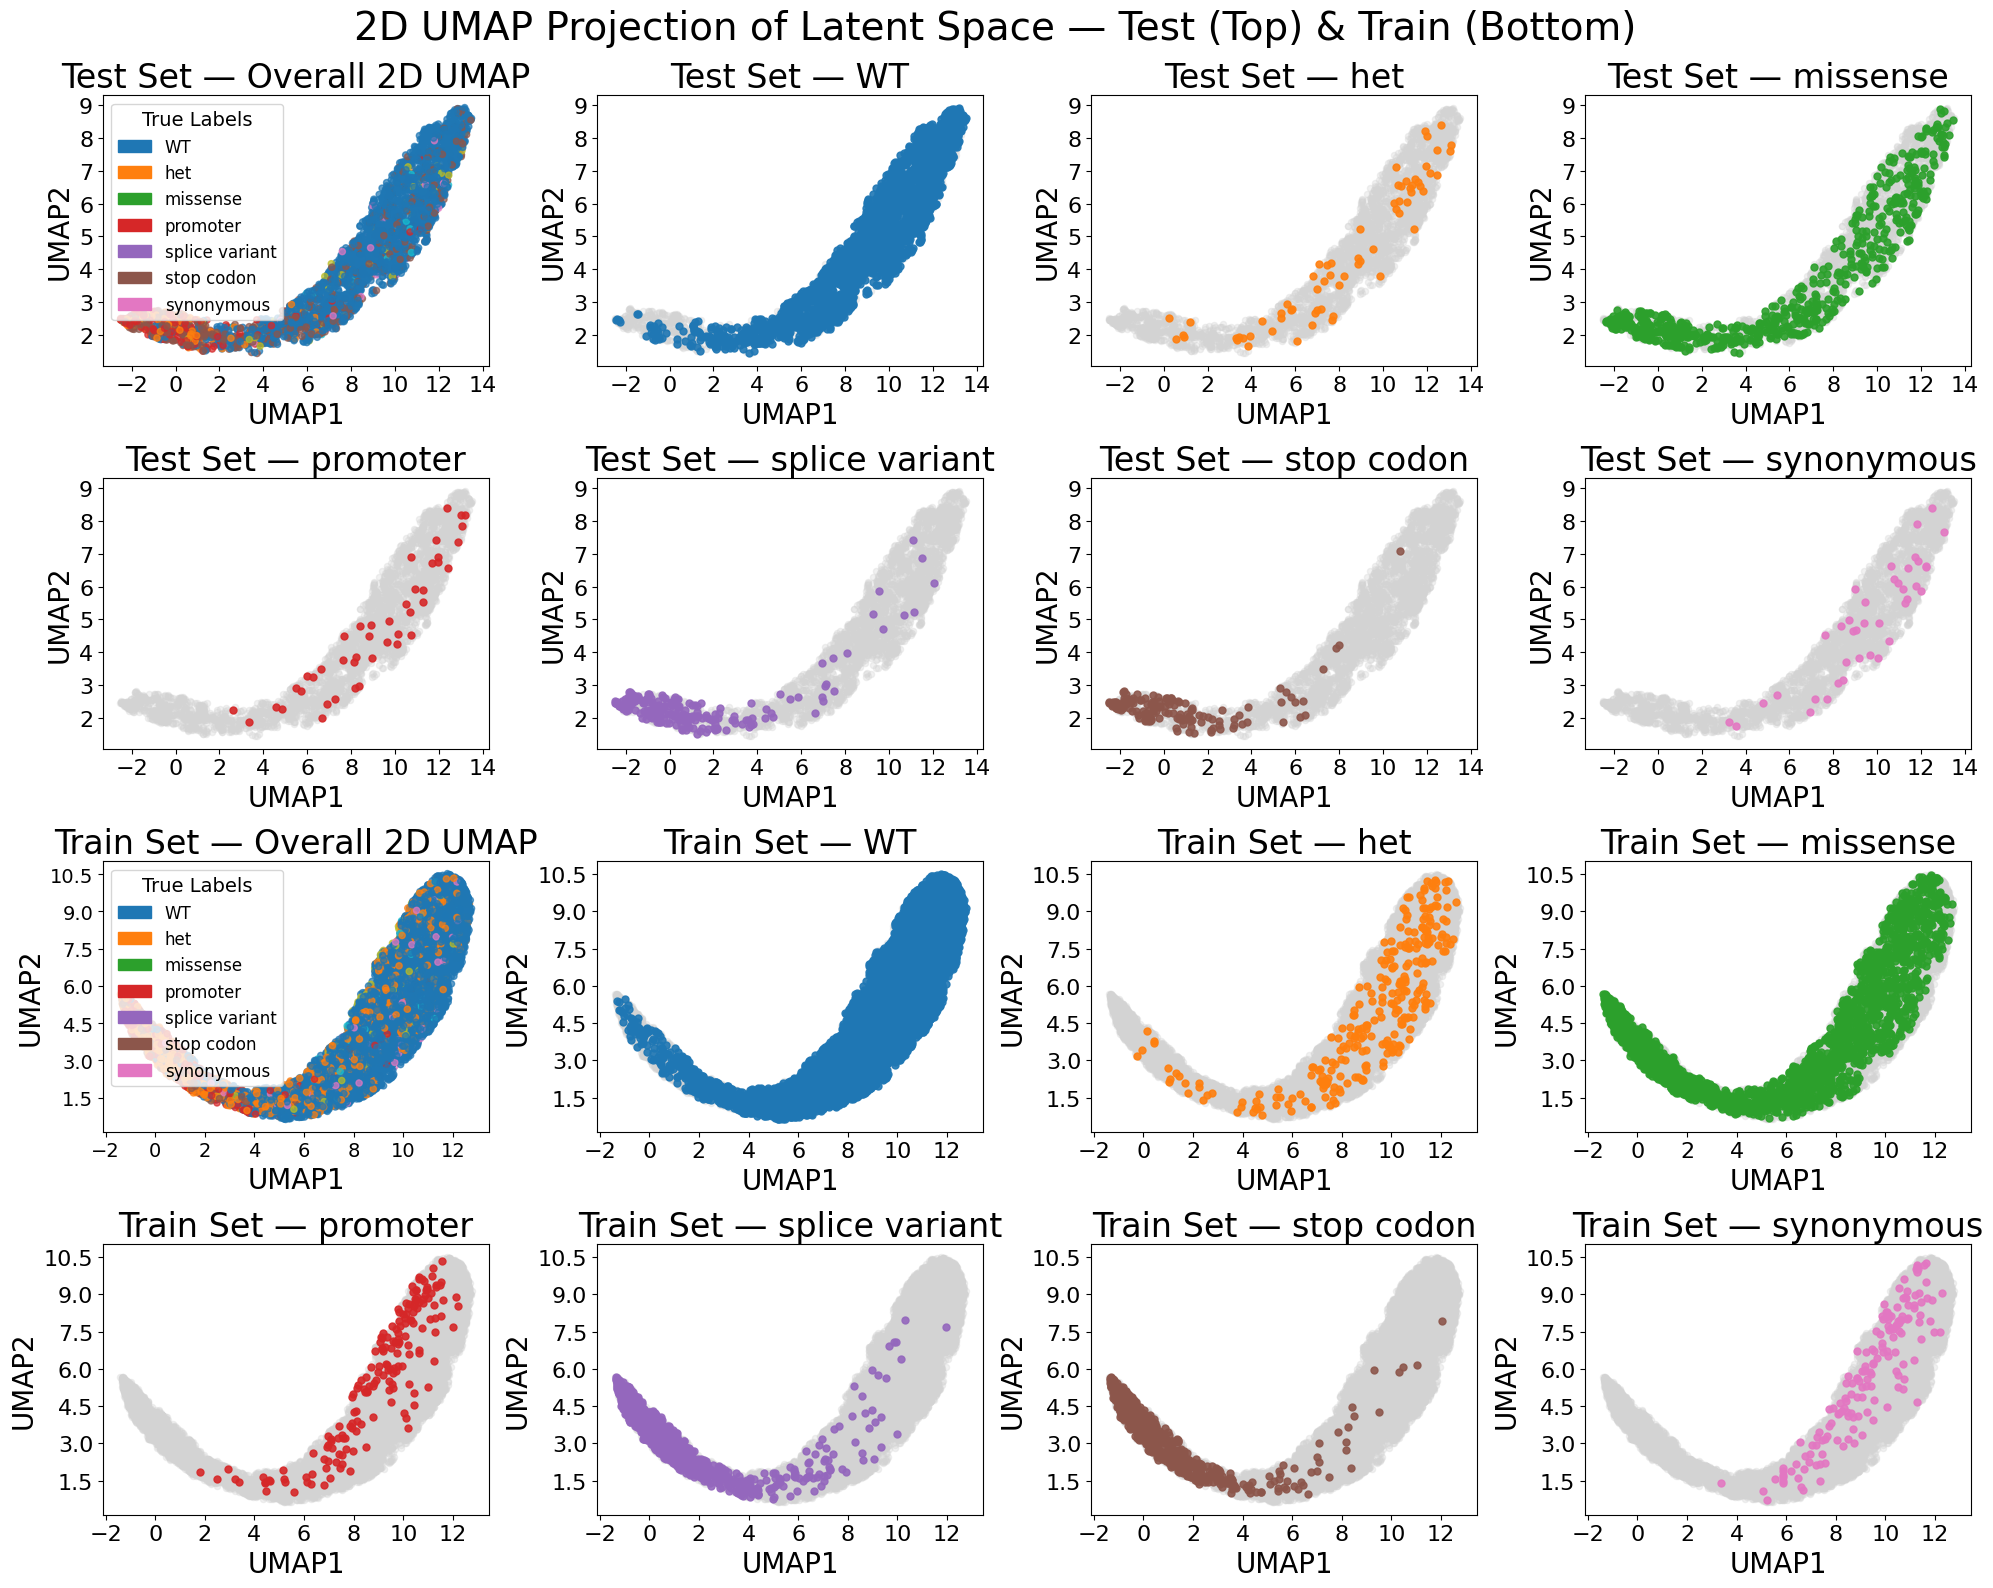

In [68]:
# ===== 2D UMAP Visualization of Encoded Latent Space (4x4 Grid) =====

# ---- Apply UMAP to encoded representations ----
umap_model_test = umap.UMAP(n_components=3, random_state=42)
latent_test = umap_model_test.fit_transform(X_test_encoded)

umap_model_train = umap.UMAP(n_components=3, random_state=42)
latent_train = umap_model_train.fit_transform(X_train_encoded)

# ---- Prepare labels ----
true_labels_test = label_encoder.inverse_transform(np.array(y_test).astype(int))
true_labels_train = label_encoder.inverse_transform(np.array(y_train).astype(int))
unique_labels = np.unique(true_labels_train)

# ---- Consistent modern colormap ----
colormap = plt.colormaps.get_cmap('tab10')

# ---- Define grid size ----
n_rows, n_cols = 4, 4  # 4x4 grid
total_slots = n_rows * n_cols

# ---- Create figure ----
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# ===========================================================
#                     TEST SET (Top Half)
# ===========================================================
# Overall plot
sc = axes[0].scatter(
    latent_test[:, 0], latent_test[:, 1],
    c=pd.factorize(true_labels_test)[0],
    cmap=colormap, alpha=0.7, s=20
)
axes[0].set_title('Test Set — Overall 2D UMAP', fontsize=24)
axes[0].set_xlabel('UMAP1', fontsize=20)
axes[0].set_ylabel('UMAP2', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].xaxis.set_major_locator(plt.MaxNLocator(prune=None))
axes[0].yaxis.set_major_locator(plt.MaxNLocator(prune=None))

# Legend
colours = [colormap(i) for i in range(len(unique_labels))]
patches = [mpatches.Patch(color=c, label=l) for c, l in zip(colours, unique_labels)]
axes[0].legend(handles=patches, title="True Labels", title_fontsize=14, fontsize=12)

# Individual class plots
for i, label in enumerate(unique_labels):
    idx = i + 1
    mask = (true_labels_test == label)
    axes[idx].scatter(latent_test[~mask, 0], latent_test[~mask, 1],
                      color='lightgrey', alpha=0.3, s=20)
    axes[idx].scatter(latent_test[mask, 0], latent_test[mask, 1],
                      color=colormap(i), alpha=0.9, s=25)
    axes[idx].set_title(f'Test Set — {label}', fontsize=24)
    axes[idx].set_xlabel('UMAP1', fontsize=20)
    axes[idx].set_ylabel('UMAP2', fontsize=20)
    axes[idx].tick_params(axis='both', which='major', labelsize=16)
    axes[idx].xaxis.set_major_locator(plt.MaxNLocator(prune=None))
    axes[idx].yaxis.set_major_locator(plt.MaxNLocator(prune=None))
    axes[idx].grid(False)

# Fill empty slots (if any)
for j in range(len(unique_labels) + 1, total_slots // 2):
    axes[j].axis('off')

# ===========================================================
#                     TRAIN SET (Bottom Half)
# ===========================================================
sc = axes[total_slots // 2].scatter(
    latent_train[:, 0], latent_train[:, 1],
    c=pd.factorize(true_labels_train)[0],
    cmap=colormap, alpha=0.7, s=20
)
axes[total_slots // 2].set_title('Train Set — Overall 2D UMAP', fontsize=24)
axes[total_slots // 2].set_xlabel('UMAP1', fontsize=20)
axes[total_slots // 2].set_ylabel('UMAP2', fontsize=20)
axes[total_slots // 2].tick_params(axis='both', which='major', labelsize=14)
axes[total_slots // 2].xaxis.set_major_locator(plt.MaxNLocator(prune=None))
axes[total_slots // 2].yaxis.set_major_locator(plt.MaxNLocator(prune=None))
axes[total_slots // 2].legend(handles=patches, title="True Labels",
                              title_fontsize=14, fontsize=12)

# Individual class plots
for i, label in enumerate(unique_labels):
    idx = total_slots // 2 + i + 1
    mask = (true_labels_train == label)
    axes[idx].scatter(latent_train[~mask, 0], latent_train[~mask, 1],
                      color='lightgrey', alpha=0.3, s=20)
    axes[idx].scatter(latent_train[mask, 0], latent_train[mask, 1],
                      color=colormap(i), alpha=0.9, s=25)
    axes[idx].set_title(f'Train Set — {label}', fontsize=24)
    axes[idx].set_xlabel('UMAP1', fontsize=20)
    axes[idx].set_ylabel('UMAP2', fontsize=20)
    axes[idx].tick_params(axis='both', which='major', labelsize=16)
    axes[idx].xaxis.set_major_locator(plt.MaxNLocator(prune=None))
    axes[idx].yaxis.set_major_locator(plt.MaxNLocator(prune=None))
    axes[idx].grid(False)

# Fill remaining slots
for j in range(total_slots // 2 + len(unique_labels) + 1, total_slots):
    axes[j].axis('off')

# ---- Final layout ----
plt.suptitle('2D UMAP Projection of Latent Space — Test (Top) & Train (Bottom)', fontsize=28, y=0.99)
plt.tight_layout()
plt.savefig("latent_space_umap_comparison.pdf", bbox_inches='tight')
plt.show()